In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedrcat/daigt-v2-train-dataset")

print("Path to dataset files:", path)

100%|██████████| 28.5M/28.5M [00:02<00:00, 11.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/thedrcat/daigt-v2-train-dataset/versions/2


In [2]:
!ls /root/.cache/kagglehub/datasets/thedrcat/daigt-v2-train-dataset/versions/2

train_v2_drcat_02.csv


In [3]:
!cp -a /root/.cache/kagglehub/datasets/thedrcat/daigt-v2-train-dataset/versions/2/train_v2_drcat_02.csv /content/train.csv

In [4]:
import pandas as pd

df = pd.read_csv('train.csv')
df.head()

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


In [5]:
df_gen = df[df['label'] == 1][['text', 'prompt_name']]
df_gen.head()

,text,prompt_name
25996,"In recent years, technology has had a profoun...",Car-free cities
25997,I strongly believe that meditation and mindful...,Distance learning
25998,One way school administrators can attempt to c...,Cell phones at school
25999,While summer is meant as a break from the regu...,Summer projects
26000,The use of Facial Action Coding System (FACS) ...,Facial action coding system


In [6]:
import numpy as np

def lzw(s: str, abc: list, d: dict = None, ret_dict: bool = False):
    d = d or {x: i for i, x in enumerate(abc)}
    k = len(d)
    x = s[0]
    ret = ""
    code_len = int(np.ceil(np.log2(k)))
    for i in range(1, len(s)):
        y = s[i]
        if x + y in d:
            x = x + y
            continue
        ret += bin(d[x])[2:].rjust(code_len, '0')
        d[x + y] = k
        k += 1
        code_len = int(np.ceil(np.log2(k)))
        x = y
    ret += bin(d[x])[2:].rjust(code_len, '0')

    if ret_dict:
        return ret, d
    return ret

abc = set()
for i in range(df_gen.shape[0]):
  abc |= set(df.iloc[i, 0].lower())

abc = list(abc)
# C = []
# for i in range(df_gen.shape[0]):
#   C.append(len(lzw(df.iloc[i, 0].lower(), abc)))

In [7]:
from scipy.special import xlogy

def entropy(prob: np.ndarray, base: float = np.e):
    return xlogy(-prob, prob).sum(axis=-1) / np.log(base)

def complexity_bound(s: np.ndarray, abc: list):
    l = len(abc)
    prob = s / s.sum()
    return (2 * l * np.log(len(s)) / np.log(l) + len(s) * entropy(prob, l)) * np.log2(l)

In [8]:
def kcd(s: np.ndarray, t: np.ndarray, cs, ct, abc: list):
    st = complexity_bound(s + t, abc)
    return max(max(st - cs, st - ct), 0)

In [9]:
def kc(freq, abc):
  return complexity_bound(freq, abc)

In [10]:
def count_characters_numpy(s, alphabet):
    alphabet = ''.join(alphabet)
    # Convert string and alphabet to numpy arrays of bytes
    s_array = np.frombuffer(s.encode(), dtype='S1')
    alphabet_array = np.array([x.encode() for x in alphabet], dtype='S1')

    # Initialize result array
    counts = np.zeros(len(alphabet), dtype=int)

    # Use broadcasting and comparison
    for i, char in enumerate(alphabet_array):
        try:
          counts[i] = np.sum(s_array == char)
        except:
          print(i, len(counts), len(alphabet))

    return counts

# Example usage
alphabet = 'abcde'
s = 'abacabad'
result = count_characters_numpy(s, alphabet)
print(result)  # Output: [4 2 1 1 0]

[4 2 1 1 0]


In [12]:
subsample_ix = np.random.choice(df_gen.shape[0], 5000, replace=False)

In [13]:
df_gen = df_gen.iloc[subsample_ix, :]

In [14]:
df_gen.shape

(5000, 2)

In [15]:
Cbound = []
F = []
for i in range(df_gen.shape[0]):
  F.append(count_characters_numpy(df_gen.iloc[i, 0].lower(), abc))
  Cbound.append(kc(F[-1], abc))

In [16]:
import torch
C = torch.load('kc.pt').numpy(force=True)[subsample_ix]

In [18]:
Cbound, F = np.array(Cbound), np.array(F)

In [14]:
Cbound = torch.tensor(Cbound)
F = torch.tensor(F)

<ipython-input-14-00a17727e7cb>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  F = torch.tensor(F)


In [19]:
Cbound.shape, F.shape, C.shape

((5000,), (5000, 107), (5000,))

In [ ]:
len(df_gen.iloc[0, 0])

1590

In [16]:
torch.log(C[:5])

tensor([9.0986, 9.1169, 8.4830, 8.6201, 9.0291])

In [ ]:
import torch
torch.save(torch.tensor(C), 'kc.pt')

In [29]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 5.3 MB/s eta 0:00:00


In [ ]:
!pip install pytorch-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [17]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertModel.from_pretrained('bert-base-cased')
model.to('cuda')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
import torch

In [18]:
%%timeit

indexed_tokens = tokenizer.encode(df_gen.iloc[0, 0], add_special_tokens=True)
model(torch.tensor([indexed_tokens]).to('cuda'))[0][0, 0].detach().cpu()

29 ms ± 3.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
df_gen.shape

(17497, 2)

In [21]:
E = []
for i in range(df_gen.shape[0]):
  text = df_gen.iloc[i, 0]
  # Tokenize and encode
  inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
  inputs = {key: val.to('cuda') for key, val in inputs.items()}

  # Forward pass
  with torch.no_grad():
      outputs = model(**inputs)

  # # Extract the [CLS] token embedding
  # cls_embedding = outputs.last_hidden_state[0, 0, :]  # shape: [batch_size, hidden_size]
  # E.append(cls_embedding.detach().cpu())

  # outputs.last_hidden_state: [1, seq_len, hidden_size]
  last_hidden_state = outputs.last_hidden_state
  attention_mask = inputs["attention_mask"]

  # --- Method 1: Mean Pooling (excluding padding tokens) ---
  # Expand mask so it's [batch_size, seq_len, 1]
  mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
  sum_embeddings = torch.sum(last_hidden_state * mask_expanded, dim=1)
  sum_mask = mask_expanded.sum(dim=1)
  mean_pooled = sum_embeddings / sum_mask
  E.append(mean_pooled.numpy(force=True))

In [ ]:
import torch
from transformers import BertTokenizer, BertModel

# Load pretrained model/tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertModel.from_pretrained('bert-base-cased')
model.to('cuda')
model.eval()

# Input text
text = "This is a sample sentence for embedding."

# Tokenize and encode
inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
inputs = {key: val.to('cuda') for key, val in inputs.items()}

# Forward pass
with torch.no_grad():
    outputs = model(**inputs)

# Extract the [CLS] token embedding
cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: [batch_size, hidden_size]
print("CLS embedding shape:", cls_embedding.shape)

CLS embedding shape: torch.Size([1, 768])


In [20]:
import torch
from transformers import BertTokenizer, BertModel

# Load pre-trained model tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()  # Disable dropout etc.

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Example sentence
sentence = "This is a test sentence."

# Tokenize and encode input
inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Get hidden states from BERT
with torch.no_grad():
    outputs = model(**inputs)

# outputs.last_hidden_state: [1, seq_len, hidden_size]
last_hidden_state = outputs.last_hidden_state
attention_mask = inputs["attention_mask"]

# --- Method 1: Mean Pooling (excluding padding tokens) ---
# Expand mask so it's [batch_size, seq_len, 1]
mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
sum_embeddings = torch.sum(last_hidden_state * mask_expanded, dim=1)
sum_mask = mask_expanded.sum(dim=1)
mean_pooled = sum_embeddings / sum_mask

print("Mean pooled shape:", mean_pooled.shape)  # (1, hidden_size)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Mean pooled shape: torch.Size([1, 768])


In [22]:
len(E)

5000

In [21]:
Ept = torch.stack(E, dim=0)
Ept.shape

torch.Size([17497, 768])

In [ ]:
torch.save(Ept, 'embeddings0405.pt')

In [ ]:
Enp = Ept.numpy()

In [ ]:
import torch, numpy as np

In [ ]:
embeddings = torch.load('embeddings0405.pt').numpy()
compl = torch.load('kc.pt').numpy()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


# Step 2: Project to 2D using t-SNE
# tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# data_2d = tsne.fit_transform(embeddings.numpy())

In [ ]:
np.save("tsne_projection0405.npy", data_2d)

In [ ]:
data_2d = np.load("tsne_projection0405.npy")

<Axes: >

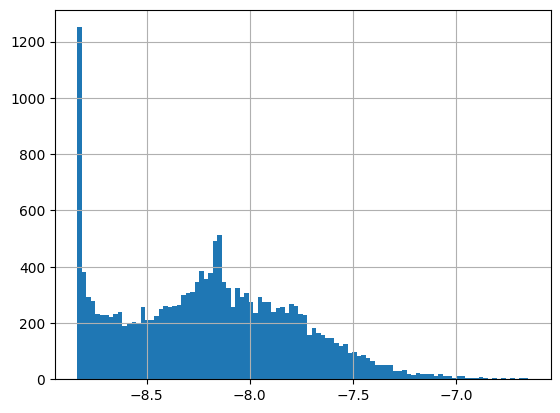

In [ ]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel='gaussian', bandwidth=0.25).fit(data_2d)

prob_scores = np.exp(kde.score_samples(data_2d))
pd.Series(np.log(prob_scores)).hist(bins=100)

<Axes: >

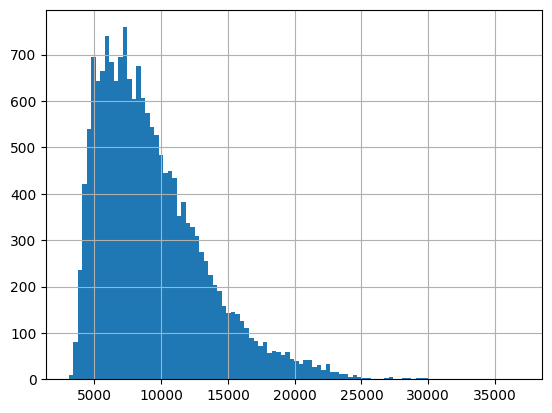

In [ ]:
pd.Series(compl).hist(bins=100)

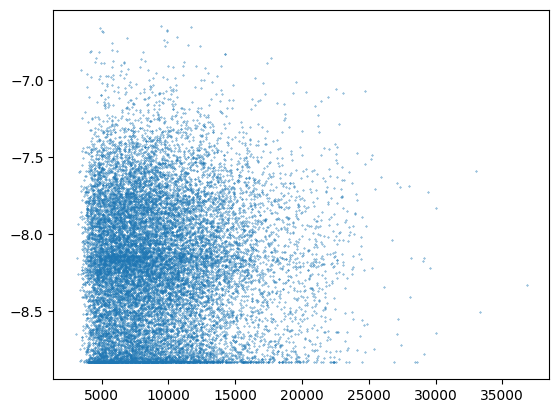

In [ ]:
plt.scatter(compl, np.log(prob_scores), s=0.1)

In [ ]:
np.corrcoef(compl, np.log(prob_scores))

array([[1.        , 0.00152336],
       [0.00152336, 1.        ]])

In [ ]:
from scipy.stats import kendalltau

kendalltau(compl, np.log(prob_scores))

SignificanceResult(statistic=np.float64(0.0016755953785639011), pvalue=np.float64(0.7396748091826215))

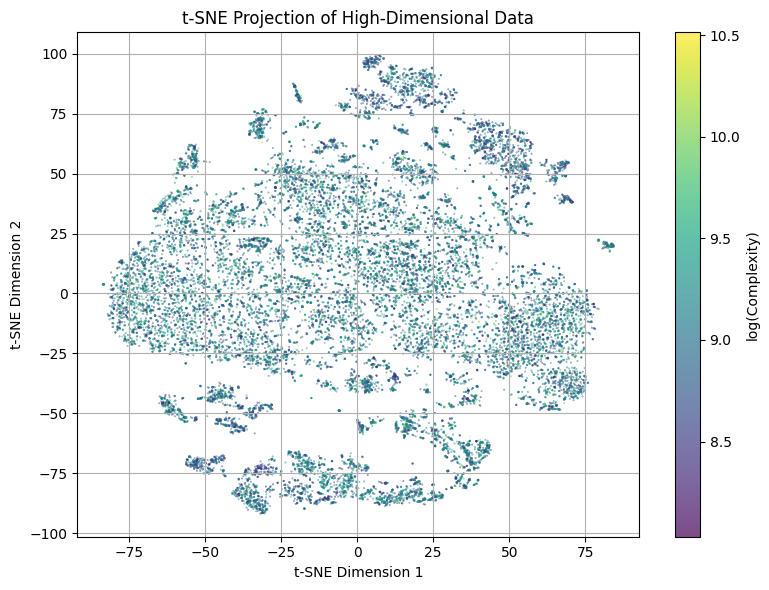

In [ ]:
# Step 3: Scatter plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], s=1000 * prob_scores, c=np.log(compl), alpha=0.7)
plt.title("t-SNE Projection of High-Dimensional Data")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.colorbar(scatter, label="log(Complexity)")
plt.show()

In [ ]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel='gaussian', bandwidth=1.0).fit(data_2d)

In [ ]:
data_2d.shape

(17497, 2)

In [ ]:
from sklearn.cluster import KMeans

# Choose number of clusters (e.g., 10 for digits)
n_clusters = 1000
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(data_2d)

# Get centroids
centroids = kmeans.cluster_centers_

# Save to file
np.save("tsne_kmeans_centroids.npy", centroids)

<ipython-input-16-f22408dda3f8>:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], cmap='tab10', s=0.1, alpha=0.6, label="Data Points")


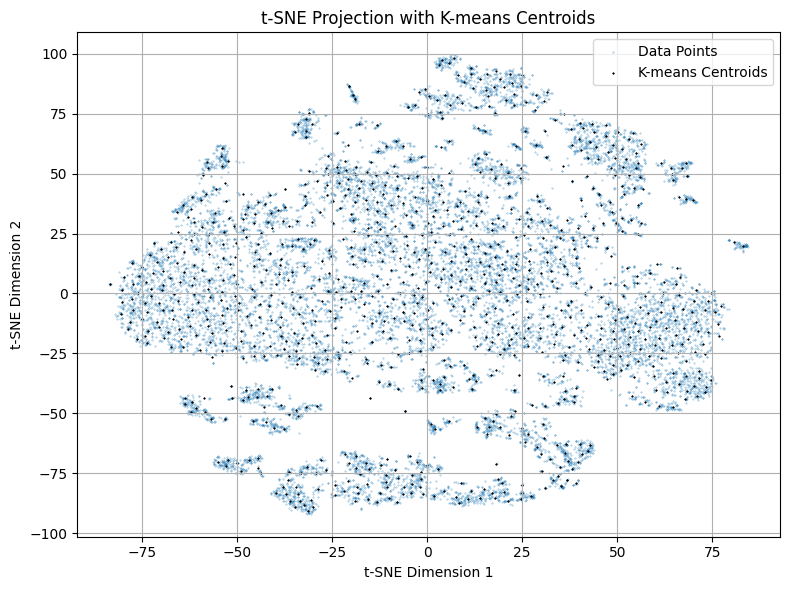

In [ ]:
plt.figure(figsize=(8, 6))

# Scatter plot of t-SNE projections
scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], cmap='tab10', s=0.1, alpha=0.6, label="Data Points")

# Overlay K-means centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=0.2, marker='X', label='K-means Centroids')

plt.title("t-SNE Projection with K-means Centroids")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
centroids = np.load("tsne_kmeans_centroids.npy")

In [ ]:
from scipy.spatial.distance import cdist

# Compute distances from centroids to all points
distances = cdist(centroids, data_2d)  # shape: (n_clusters, n_samples)

# Get the index of the closest point to each centroid
nearest_indices = distances.argmin(axis=1)

# Get those closest points
nearest_points = data_2d[nearest_indices]

In [ ]:
distances.min()

np.float64(0.0013008341409767193)

In [ ]:
def log_integrate_region(center, radius, n_samples=10):
    # Uniform samples in square around center
    samples = np.random.uniform(low=center - radius, high=center + radius, size=(n_samples, 2))
    log_probs = kde.score_samples(samples)
    return np.log2(np.mean(np.exp(log_probs))) + np.log2(4 * radius**2)

In [ ]:
from scipy.optimize import minimize_scalar

# Suppose you have K centroids and empirical probabilities
def objective_radius(r):
    estimated_pmf = []
    for center in nearest_points:
        log2_p = min(-1e-6, log_integrate_region(center, r))
        estimated_pmf.append(log2_p)
    estimated_pmf = np.array(estimated_pmf)
    estimated_pmf -= (compl[nearest_indices] + estimated_pmf).mean()
    return np.mean((compl[nearest_indices] + estimated_pmf)**2)  # or KL divergence

result = minimize_scalar(objective_radius, bounds=(0.001, 1.0), method='bounded')
best_radius = result.x

In [ ]:
result

 message: Solution found.
 success: True
  status: 0
     fun: 16339671.925035723
       x: 0.6776921505567942
     nit: 25
    nfev: 25

In [ ]:
estimated_pmf = []
for center in nearest_points:
    log2_p = min(-1e-6, log_integrate_region(center, result.x))
    estimated_pmf.append(log2_p)
estimated_pmf = np.array(estimated_pmf)
estimated_pmf -= (compl[nearest_indices] + estimated_pmf).mean()
np.abs(compl[nearest_indices] + estimated_pmf).mean()  # or KL divergence

np.float64(3103.1080255374313)

In [ ]:
estimated_pmf.mean()

np.float64(-9407.648)

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Step 2: Fit linear regression
model = LinearRegression()
model.fit(-estimated_pmf.reshape(-1, 1), compl[nearest_indices])
y_pred = model.predict(-estimated_pmf.reshape(-1, 1))

# Step 3: Compute metrics
mae = mean_absolute_error(compl[nearest_indices], y_pred)
r2 = r2_score(compl[nearest_indices], y_pred)

# Output results
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"R² Score: {r2:.3f}")

Mean Absolute Error (MAE): 3102.622
R² Score: 0.000


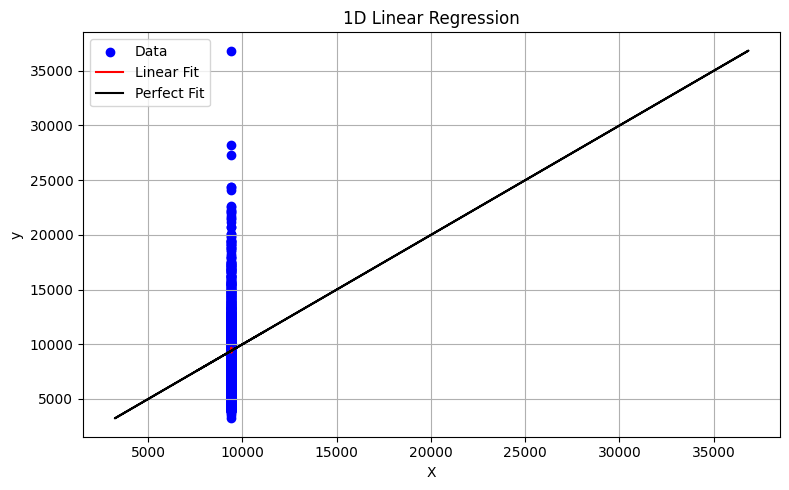

In [ ]:
import matplotlib.pyplot as plt

X, y = -estimated_pmf, compl[nearest_indices]

plt.figure(figsize=(8, 5))
plt.scatter(X, y, color='blue', label='Data')
plt.plot(X, y_pred, color='red', label='Linear Fit')
plt.plot(y, y, color='black', label='Perfect Fit')
plt.title("1D Linear Regression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
from sklearn.neighbors import NearestNeighbors

def mle(X: np.ndarray, k: int = 5, distances: bool = False):
    nn = NearestNeighbors(n_neighbors=k, metric='precomputed' if distances else 'minkowski').fit(X)
    dist, _ = nn.kneighbors()

    return (k - 1) / np.log(np.expand_dims(dist[:, -1], 1) / dist).sum(axis=-1)

def beta1(x: np.ndarray, y: np.ndarray) -> float:
    return np.sum(x*y) / np.square(x).sum()

def beta1_intercept(x: np.ndarray, y: np.ndarray) -> float:
    n = x.size
    return (np.sum(x*y) - n*x.mean()*y.mean()) / (np.sum(x*x) - n*x.mean()*x.mean())

def two_nn(X: np.ndarray, distances: bool = False):
    n = X.shape[0]
    nn = NearestNeighbors(n_neighbors=2, metric='precomputed' if distances else 'minkowski').fit(X)
    dist, _ = nn.kneighbors()
    return beta1(np.log(np.sort(dist[:, 1] / dist[:, 0])), -np.log(1 - np.linspace(0, 1 - 1 / n, n)))

def corr(X: np.ndarray):
    iu = np.triu_indices(X.shape[1], 1)
    d = np.copy(X[iu])
    d.sort()
    c = 2 * np.arange(1, d.shape[0] + 1) / (X.shape[0] - 1) / X.shape[0]
    return np.abs(beta1_intercept(np.log(d), np.log(c)))

def mm(X: np.ndarray, k: int = 5, distances: bool = False):
    nn = NearestNeighbors(n_neighbors=k, metric='precomputed' if distances else 'minkowski').fit(X)
    dist, _ = nn.kneighbors()

    Tk = dist[:, -1]
    T = dist.mean(axis=1)
    return T / (Tk - T)

In [24]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import gaussian_kde

def metric_kde_from_distances(bandwidth):
    """
    Estimate density using a distance-based Gaussian KDE.

    Parameters:
    - bandwidth: kernel bandwidth (scalar)

    Returns:
    - density_fn: function to compute density at out-of-sample points
    """

    def kde_density(distances_to_anchors):
        # distances_to_anchors: (n_anchors,) array of distances from new point to anchor points
        kernels = np.exp(-0.5 * (distances_to_anchors / bandwidth) ** 2)
        return np.mean(kernels) / (bandwidth * np.sqrt(2 * np.pi))

    return kde_density

# ------------------------------
# Example usage
# ------------------------------

# Simulate 1D data for clarity
np.random.seed(42)
X_train = np.random.normal(loc=0, scale=1, size=(100, 1))

# Use Euclidean distance
D_train = cdist(X_train, X_train, metric='euclidean')

# Fit density estimator using distances
bandwidth = 0.5
kde_fn = metric_kde_from_distances(bandwidth)

# Now estimate density at a new point (e.g., x = 1.5)
x_new = np.array([[1.5]])
d_new = cdist(x_new, X_train, metric='euclidean')[0]

density_at_x_new = kde_fn(d_new)
print(f"Estimated density at x=1.5: {density_at_x_new:.4f}")

Estimated density at x=1.5: 0.1242


In [26]:
from scipy.spatial.distance import pdist

E = E.squeeze()
E.shape

(5000, 768)

In [26]:
Enp = np.stack(E)
Enp.shape

(17497, 768)

In [27]:
dist = pdist(E)

In [28]:
from scipy.spatial.distance import squareform

dist = squareform(dist)

<Axes: >

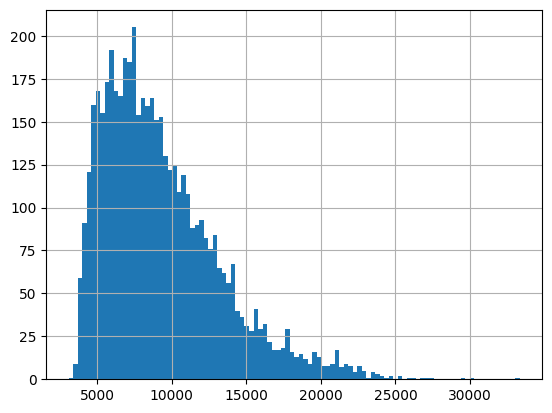

In [38]:
pd.Series(C).hist(bins=100)

<Axes: >

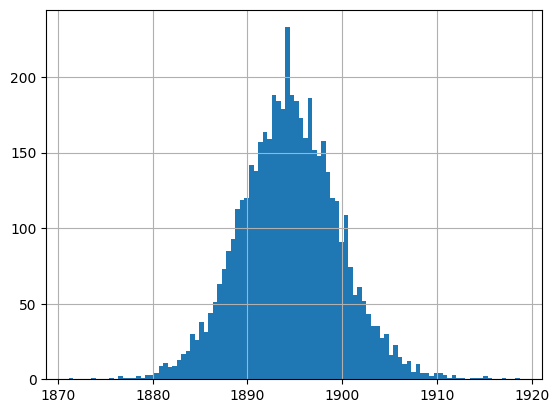

In [39]:
pd.Series(Cbound).hist(bins=100)

<Axes: >

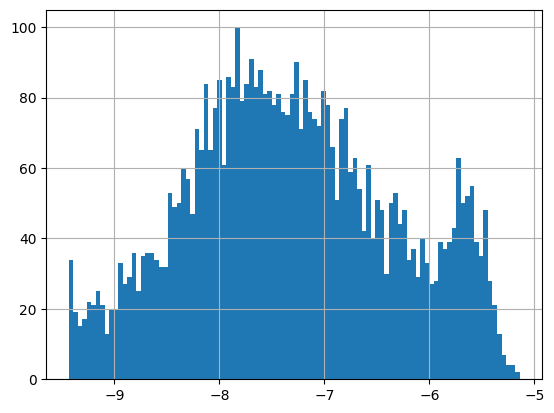

In [31]:
import pandas as pd

# Fit density estimator using distances
bandwidth = 1
kde_fn = metric_kde_from_distances(bandwidth)

scores = []
for i in range(dist.shape[0]):
  # Now estimate density at a new point (e.g., x = 1.5)
  d_new = dist[i].reshape(1, -1)
  density_at_x_new = np.log(kde_fn(d_new))
  scores.append(density_at_x_new)

pd.Series(scores).hist(bins=100)

In [33]:
from scipy.stats import kendalltau, pearsonr, linregress, spearmanr
print("Algorithmic:")
for cc in (kendalltau, pearsonr, linregress, spearmanr):
  print(cc(scores, C))
print("\nBound:")
for cc in (kendalltau, pearsonr, linregress, spearmanr):
  print(cc(scores, Cbound))

Algorithmic:
SignificanceResult(statistic=np.float64(-0.048077698947075476), pvalue=np.float64(3.4800860333035637e-07))
PearsonRResult(statistic=np.float64(-0.07652860798750007), pvalue=np.float64(6.027505567970335e-08))
LinregressResult(slope=np.float64(-307.96858955302724), intercept=np.float64(7063.906679596901), rvalue=np.float64(-0.07652860798750002), pvalue=np.float64(6.027505567970407e-08), stderr=np.float64(56.755636043301315), intercept_stderr=np.float64(418.9865465300116))
SignificanceResult(statistic=np.float64(-0.07322223774566233), pvalue=np.float64(2.180430254196192e-07))

Bound:
SignificanceResult(statistic=np.float64(-0.05095483096619324), pvalue=np.float64(6.565069455223771e-08))
PearsonRResult(statistic=np.float64(-0.07623978244224258), pvalue=np.float64(6.758509871069699e-08))
LinregressResult(slope=np.float64(-0.40323547825039024), intercept=np.float64(1891.5192897460793), rvalue=np.float64(-0.07623978244224255), pvalue=np.float64(6.75850987106954e-08), stderr=np.fl

In [34]:
def mle_aggregate(dim: np.ndarray):
    return 1 / np.mean(1 / dim)

In [35]:
corr(dist), two_nn(dist, True)

(np.float64(5.236701893645117), np.float64(17.770451364690228))

<Axes: >

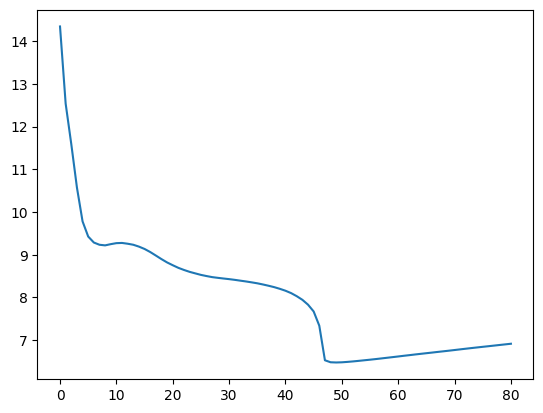

In [36]:
d = []
for x in range(10, 820, 10):
  d.append(mle_aggregate(mle(dist, x, True)))
pd.Series(d).plot()

<Axes: >

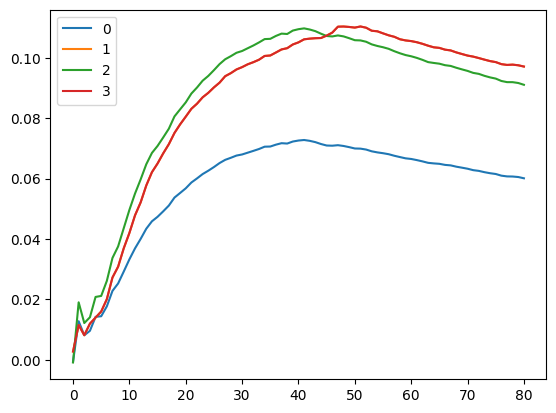

In [40]:
res = [list() for i in range(4)]
for x in range(10, 820, 10):
  dim = mle(dist, x, True)
  for i, cc in enumerate((kendalltau, pearsonr, spearmanr)):
    res[i].append(cc(dim, C).statistic)
  res[-1].append(linregress(dim, C).rvalue)
pd.DataFrame(res).T.plot()

<Axes: >

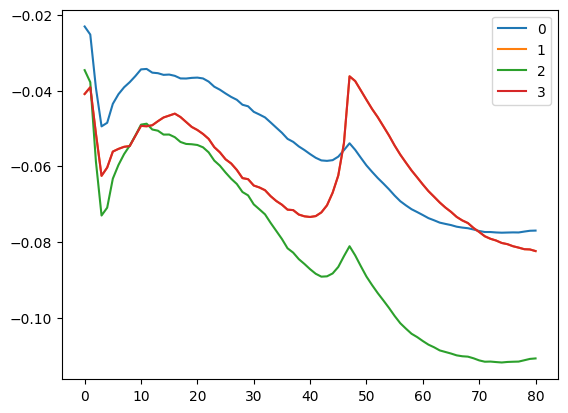

In [45]:
res = [list() for i in range(4)]
for x in range(10, 820, 10):
  dim = mle(dist, x, True)
  for i, cc in enumerate((kendalltau, pearsonr, spearmanr)):
    res[i].append(cc(dim, Cbound).statistic)
  res[-1].append(linregress(dim, Cbound).rvalue)
pd.DataFrame(res).T.plot()

In [41]:
X = np.stack([
    mle(dist, 100, True),
    mm(dist, 100, True),
    scores
], axis=-1)
y = C

In [42]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 4. Define models to compare
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor()
}

# 5. Train, predict, and assess models
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2
    })

# 6. Show results
results_df = pd.DataFrame(results).sort_values(by="R²", ascending=False)
print(results_df)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.857e+09, tolerance: 6.330e+06
  model = cd_fast.enet_coordinate_descent(


              Model          MAE           MSE         RMSE        R²
0  LinearRegression  3010.188085  1.549695e+07  3936.616946  0.009560
1             Ridge  3010.339174  1.549948e+07  3936.938162  0.009398
2             Lasso  3010.706808  1.550582e+07  3937.742546  0.008993
5  GradientBoosting  3037.147289  1.587474e+07  3984.311300 -0.014585
6               SVR  2966.054032  1.637966e+07  4047.178835 -0.046856
4      RandomForest  3254.728240  1.786493e+07  4226.692021 -0.141782
7               KNN  3250.385800  1.793511e+07  4234.986226 -0.146268
3      DecisionTree  4393.478000  3.387392e+07  5820.130292 -1.164948


In [43]:
y = Cbound

In [44]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 4. Define models to compare
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor()
}

# 5. Train, predict, and assess models
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2
    })

# 6. Show results
results_df = pd.DataFrame(results).sort_values(by="R²", ascending=False)
print(results_df)

              Model       MAE        MSE      RMSE        R²
5  GradientBoosting  3.946350  26.837181  5.180461  0.040420
6               SVR  3.979358  26.943856  5.190747  0.036606
0  LinearRegression  4.048007  27.530150  5.246918  0.015642
1             Ridge  4.048321  27.533139  5.247203  0.015536
2             Lasso  4.090915  27.978412  5.289462 -0.000385
4      RandomForest  4.150755  30.008805  5.478029 -0.072983
7               KNN  4.267330  31.624156  5.623536 -0.130741
3      DecisionTree  5.692044  54.253674  7.365709 -0.939874


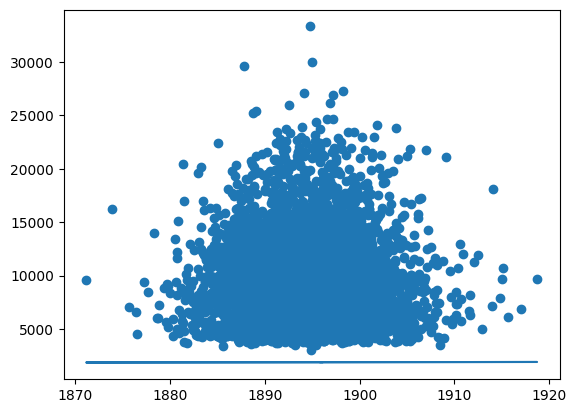

In [47]:
import matplotlib.pyplot as plt

plt.scatter(Cbound, C)
plt.plot(Cbound, Cbound)

In [48]:
for cc in (kendalltau, pearsonr, linregress, spearmanr):
  print(cc(Cbound, C))

SignificanceResult(statistic=np.float64(0.008328831260780304), pvalue=np.float64(0.37739243912807185))
PearsonRResult(statistic=np.float64(0.014033978760429002), pvalue=np.float64(0.32112294757175314))
LinregressResult(slope=np.float64(10.677912000205751), intercept=np.float64(-10911.986516102223), rvalue=np.float64(0.014033978760429005), pvalue=np.float64(0.3211229475717569), stderr=np.float64(10.761297174660815), intercept_stderr=np.float64(20387.02504017671))
SignificanceResult(statistic=np.float64(0.012370808054656552), pvalue=np.float64(0.3818117400986659))
